# Configurando o colab


In [0]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/Shared\ drives/cd2019-trabalho
%ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/Shared drives/cd2019-trabalho
AudioFeatures.ipynb  cloud_fetch.ipynb  fma_small.zip     Untitled0.ipynb
audio-sandbox.ipynb  fma_metadata/      mfcc.ipynb
bibliografia/        fma_metadata.zip   pyAudioAnalysis/
classifiers.ipynb    fma_small/         test.ipynb


# Adicionando Bibliotecas, lendo e plotando audio

In [0]:
import librosa
import pandas as pd
import numpy as np
import math
import sklearn
from scipy.signal import get_window
import scipy.fftpack as fft

import IPython.display as ipd # Tocando o audio

%matplotlib inline
import matplotlib.pyplot as plt   # Visualizando a waveform
import librosa.display

<class 'numpy.ndarray'> <class 'int'>
(661560,) 22050 30.002721088435376


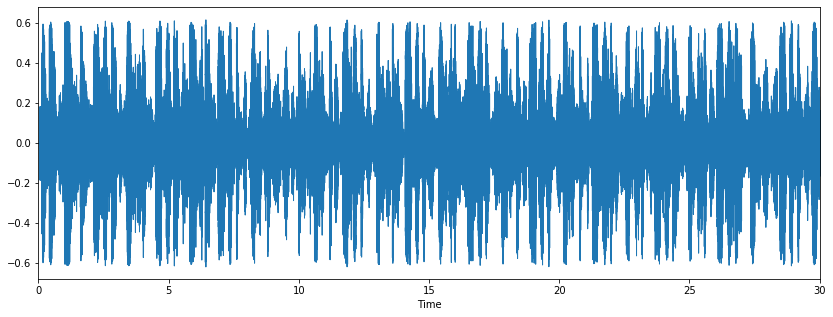

In [0]:

audio_path = 'fma_small/000/000005.mp3'
audio_time , sr = librosa.load(audio_path)

print(type(audio_time), type(sr))
print(audio_time.shape, sr, len(audio_time)/sr)

ipd.Audio(audio_path) # tocando o audio

plt.figure(figsize=(14, 5)) #Visualizando a waveform
librosa.display.waveplot(audio_time, sr=sr)

# MFCC

O MFCC usa a escala MEL para dividir a frenquencia de banda em sub-bandas e então extrair os coeficientes cepstron

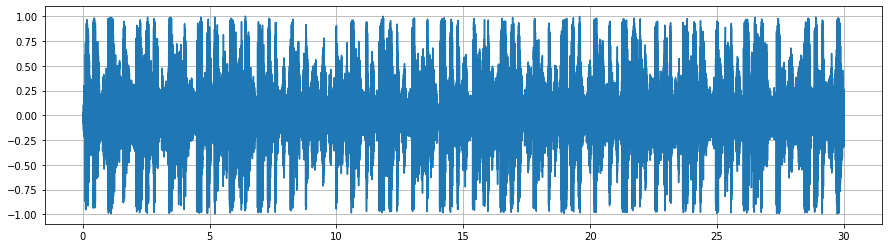

In [0]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

audio = normalize_audio(audio_time)
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sr, num=len(audio)), audio)
plt.grid(True)

### Audio Framing

Criando as janelas (frames)

In [0]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames


hop_size = 15 #ms
FFT_size = 2048

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sr)
print("Framed audio shape: {0}".format(audio_framed.shape))


print("First frame:")
audio_framed[1]



Framed audio shape: (1999, 2048)
First frame:


array([-0.10213569, -0.1232172 , -0.13500147, ..., -0.08292172,
       -0.08492193, -0.10004516])

### Convert to frequency domain

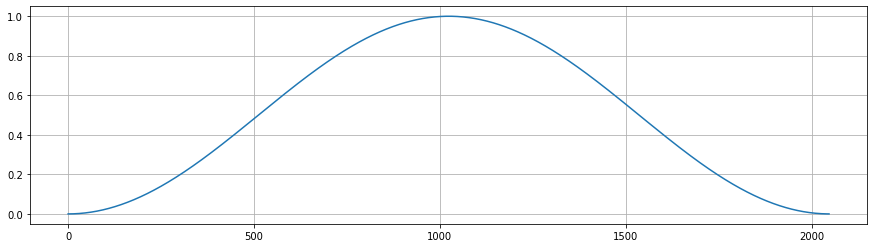

In [0]:
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

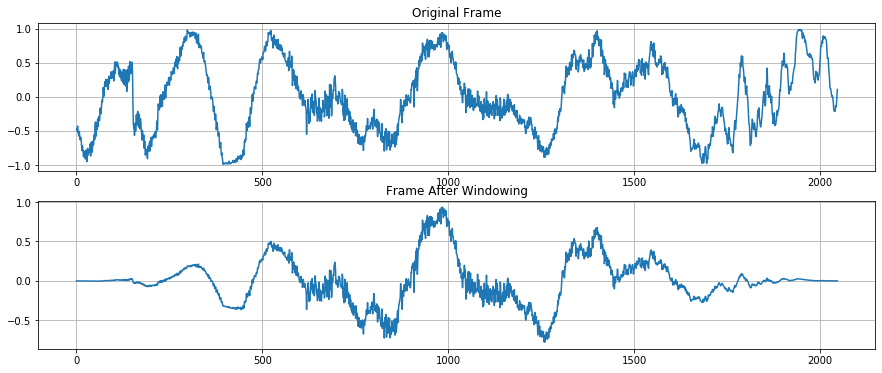

In [0]:
audio_win = audio_framed * window

ind = 69
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

In [0]:
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

### Calculate Power

In [0]:


audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)



(1999, 1025)


### MEL Space Fiterbank

In [0]:
freq_min = 0
freq_high = sr / 2
mel_filter_num = 10

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))


Minimum frequency: 0
Maximum frequency: 11025.0


#### Compute Fiter Points

In [0]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [0]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [0]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)
filter_points

MEL min: 0.0
MEL max: 3176.318435512582


array([  0,   9,  21,  37,  58,  84, 118, 162, 220, 293, 389, 512])

#### Construct Fiter Bank

In [0]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

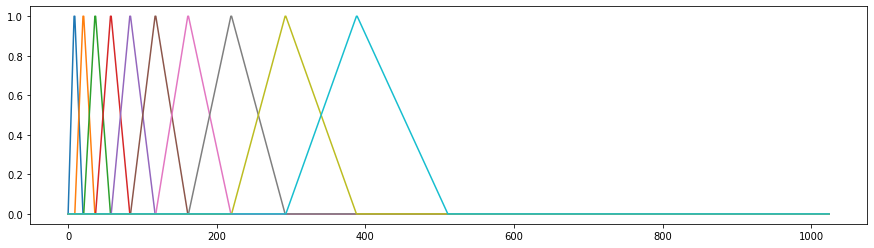

In [0]:
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])


In [0]:
# taken from the librosa library
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

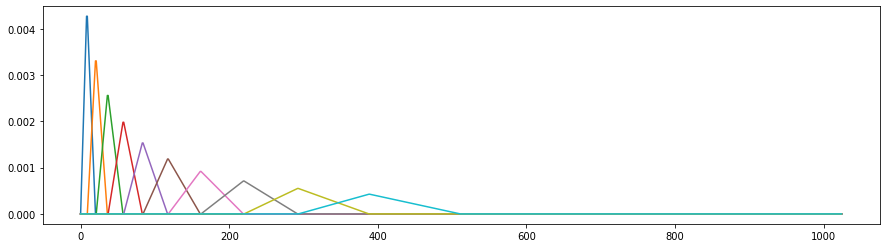

In [0]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

### Filter Signal

In [0]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape



(10, 1999)

### Generate the Cepstral Coefficients


In [0]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [0]:
dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(40, 1999)

### Reviwing the cepstral coefficients

In [0]:
cepstral_coefficents[:, 0]

array([-5.68187594e+01,  2.76239941e+01, -5.95695317e+00,  6.45500071e+00,
        1.25805100e-01,  5.83116693e+00, -6.08718204e-01, -1.58858747e-01,
       -1.42649077e+00, -1.82054837e-01,  1.13171789e-13,  1.82054837e-01,
        1.42649077e+00,  1.58858747e-01,  6.08718204e-01, -5.83116693e+00,
       -1.25805100e-01, -6.45500071e+00,  5.95695317e+00, -2.76239941e+01,
        8.03538602e+01, -2.76239941e+01,  5.95695317e+00, -6.45500071e+00,
       -1.25805100e-01, -5.83116693e+00,  6.08718204e-01,  1.58858747e-01,
        1.42649077e+00,  1.82054837e-01, -7.79130977e-14, -1.82054837e-01,
       -1.42649077e+00, -1.58858747e-01, -6.08718204e-01,  5.83116693e+00,
        1.25805100e-01,  6.45500071e+00, -5.95695317e+00,  2.76239941e+01])

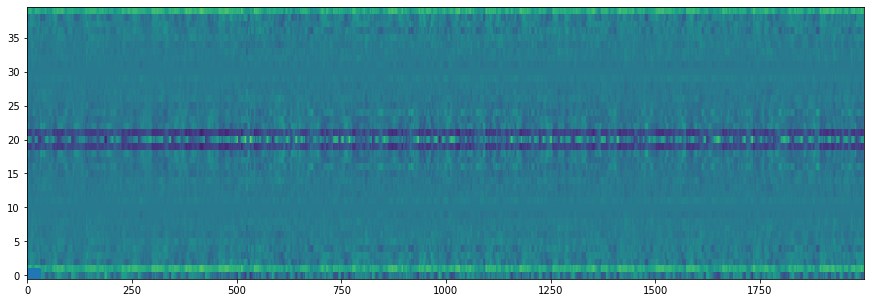

In [0]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sr, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');

# Spectral Entropy

Recuperando o espectro

In [0]:
def windows_spectra(signal, *args, **kwargs):
  for w in windows(signal, *args, **kwargs):
    yield np.fft.fft(w)

Calculando a potencia

In [0]:
audio_power = np.square(np.abs(audio_fft))

In [0]:
def spectral_entropy(signal, nw, *args, **kwargs):
  ret = []

  # Frame
  for w in windows(signal, nw=nw):
    coeff = []
    # Calculando cada sub_frame
    for sub_coef in windows(w, nw=nw):
      coeff.append((sub_coef ** 2) / len(sub_coef))

    # Calculando a energia do frame
    for values in coeff:
      frame_energy += values ** 2

    frame_energy = frame_energy / len(w)

    nvalue = coeff / frame_energy
    
    # mags *= np.hanning(len(mags))  # Aply Hann's windowing function
    ret.append((-np.sum(nvalue * np.log2(nvalue)))
  
  return ret